# LINGER ANALYSIS

In this notebook, we present a GNR inference, largely based on the works of:
> [Yuan, Qiuyue, and Zhana Duren. "Inferring gene regulatory networks from single-cell multiome data using atlas-scale external data." Nature Biotechnology (2024): 1-11.](https://doi.org/10.1038/s41587-024-02182-7)

and the tutorial available at [LINGER's Github](https://github.com/Durenlab/LINGER/blob/main/docs/PBMC.md).

The data used are output files from ***PBMC from a Healthy Donor - Granulocytes Removed Through Cell Sorting (10k)*** *Single Cell Multiome ATAC + Gene Expression experiment* on *10X Chromium* platform analysed with Cell Ranger ARC, which are available on [10XGenomics website](https://www.10xgenomics.com/datasets/pbmc-from-a-healthy-donor-granulocytes-removed-through-cell-sorting-10-k-1-standard-2-0-0). Cell type annotations were downloaded from [PBMC tutorial](https://github.com/Durenlab/LINGER/blob/main/docs/PBMC.md).

## Preparation steps

In [1]:
%matplotlib inline
import os
os.chdir('/home/kl467102/thesis/')

In [2]:
import scanpy as sc
import scipy
import pandas as pd
import time
import os

In [4]:
input_dir = 'data/filtered_feature_bc_matrix' # path to 10x output files
label_file = 'data/PBMC_label.txt' # path to cell-type annotations

The input consists of `matrix.mtx`, `features.tsv` and `barcodes.tsv` and an annotation file.

In [5]:
matrix=scipy.io.mmread(os.path.join(input_dir, 'matrix.mtx'))
features=pd.read_csv(os.path.join(input_dir, 'features.tsv'), sep='\t', header=None)
barcodes=pd.read_csv(os.path.join(input_dir, 'barcodes.tsv'), sep='\t', header=None)
label=pd.read_csv(label_file, sep='\t', header=0)

We have loaded the data, now we can inspect them.

In [6]:
matrix.shape

(180488, 11898)

In [7]:
pd.concat([features.head(2), features.tail(2)])

,0,1,2,3,4,5
0,ENSG00000243485,MIR1302-2HG,Gene Expression,chr1,29553,30267
1,ENSG00000237613,FAM138A,Gene Expression,chr1,36080,36081
180486,KI270713.1:31340-32243,KI270713.1:31340-32243,Peaks,KI270713.1,31340,32243
180487,KI270713.1:36927-37836,KI270713.1:36927-37836,Peaks,KI270713.1,36927,37836


In [8]:
barcodes.head(3)

,0
0,AAACAGCCAAGGAATC-1
1,AAACAGCCAATCCCTT-1
2,AAACAGCCAATGCGCT-1


In [9]:
label.head(3)

,barcode_use,label
0,AAACAGCCAAGGAATC-1,naive CD4 T cells
1,AAACAGCCAATCCCTT-1,memory CD4 T cells
2,AAACAGCCAATGCGCT-1,naive CD4 T cells


## Step 1 - preprocessing

### Extraction of matrices for RNASeq and ATACSeq

In [11]:
from LingerGRN.preprocess import *
adata_RNA, adata_ATAC = get_adata(matrix, features, barcodes, label)

/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/LingerGRN/preprocess.py:278: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_RNA.obs['label']=label.loc[adata_RNA.obs['barcode']]['label'].values
/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/LingerGRN/preprocess.py:281: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ATAC.obs['label']=label.loc[adata_ATAC.obs['barcode']]['label'].values


### Removing low count cells

In [12]:
sc.pp.filter_cells(adata_RNA, min_genes=200)
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.filter_cells(adata_ATAC, min_genes=200)
sc.pp.filter_genes(adata_ATAC, min_cells=3)

/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [13]:
# Find common barcodes between RNA and ATAC datasets
selected_barcode = list(set(adata_RNA.obs['barcode']) & set(adata_ATAC.obs['barcode']))

# Filter both datasets to keep only the shared barcodes
adata_RNA = adata_RNA[adata_RNA.obs['barcode'].isin(selected_barcode)]
adata_ATAC = adata_ATAC[adata_ATAC.obs['barcode'].isin(selected_barcode)]

### Generating metacells

Metacells are generated to create more stable, representative profiles of groups of cells. 

In [14]:
from LingerGRN.pseudo_bulk import *

In [15]:
samplelist=list(set(adata_ATAC.obs['sample'].values)) 
tempsample=samplelist[0]
TG_pseudobulk=pd.DataFrame([])
RE_pseudobulk=pd.DataFrame([])

In [16]:
singlepseudobulk = (adata_RNA.obs['sample'].unique().shape[0]*adata_RNA.obs['sample'].unique().shape[0]>100)
for tempsample in samplelist:
    adata_RNAtemp=adata_RNA[adata_RNA.obs['sample']==tempsample]
    adata_ATACtemp=adata_ATAC[adata_ATAC.obs['sample']==tempsample]
    TG_pseudobulk_temp,RE_pseudobulk_temp=pseudo_bulk(adata_RNAtemp,adata_ATACtemp,singlepseudobulk)                
    TG_pseudobulk=pd.concat([TG_pseudobulk, TG_pseudobulk_temp], axis=1)
    RE_pseudobulk=pd.concat([RE_pseudobulk, RE_pseudobulk_temp], axis=1)
    RE_pseudobulk[RE_pseudobulk > 100] = 100

/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Write preprocessed data to a file:

In [17]:
linger_storage = 'results/linger_storage'
os.makedirs(linger_storage, exist_ok = True)

adata_ATAC.write(os.path.join(linger_storage,'adata_ATAC.h5ad'))
adata_RNA.write(os.path.join(linger_storage,'adata_RNA.h5ad'))
TG_pseudobulk=TG_pseudobulk.fillna(0)
RE_pseudobulk=RE_pseudobulk.fillna(0)
pd.DataFrame(adata_ATAC.var['gene_ids']).to_csv('data/Peaks.txt',header=None,index=None) #hard coded path to Peaks in preprocess
TG_pseudobulk.to_csv(os.path.join(linger_storage,'TG_pseudobulk.tsv'))
RE_pseudobulk.to_csv(os.path.join(linger_storage,'RE_pseudobulk.tsv'))

/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/kl467102/miniconda3/envs/linger_enviroment/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


## Step 2 - training

In [21]:
method = 'LINGER'
Datadir = '/home/kl467102/proj_v0/downloads/' # Directory for the downloaded general gene regulatory network for LINGER
GRNdir = Datadir+'data_bulk/'
genome = 'hg38'
outdir = os.path.join(os.getcwd(),'results/LINGER_output/')
os.makedirs(outdir, exist_ok = True)

NOTE TO SELF: Because of `pybedtools` dependency `outdir` needs to be specified as an absolute path, otherwise resulting in an error

In [22]:
from LingerGRN.preprocess import *

In [24]:
preprocess(TG_pseudobulk,RE_pseudobulk,GRNdir,genome,method,outdir)

Mapping gene expression...
Generate TF expression...
Generate RE chromatin accessibility...
Generate TF binding...


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [1:12:17<00:00, 188.60s/it]


Generate Index...


100%|█████████████████████████████████████████████████████████████████████████████| 14907/14907 [05:31<00:00, 44.97it/s]


In [25]:
import LingerGRN.LINGER_tr as LINGER_tr

In [ ]:
activef='ReLU'
LINGER_tr.training(GRNdir,method,outdir,activef,'Human')

chr1


100%|████████████████████████████████████████████████████████████████████████████| 1520/1520 [24:20:34<00:00, 57.65s/it]


chr2


100%|██████████████████████████████████████████████████████████████████████████████| 976/976 [12:55:38<00:00, 47.68s/it]


chr3


100%|██████████████████████████████████████████████████████████████████████████████| 870/870 [10:01:27<00:00, 41.48s/it]


chr4


100%|███████████████████████████████████████████████████████████████████████████████| 565/565 [5:23:46<00:00, 34.38s/it]


chr5


100%|███████████████████████████████████████████████████████████████████████████████| 669/669 [6:06:18<00:00, 32.85s/it]


chr6


100%|███████████████████████████████████████████████████████████████████████████████| 759/759 [7:27:43<00:00, 35.39s/it]


chr7


100%|███████████████████████████████████████████████████████████████████████████████| 699/699 [6:43:27<00:00, 34.63s/it]


chr8


100%|███████████████████████████████████████████████████████████████████████████████| 508/508 [5:00:31<00:00, 35.49s/it]


chr9


100%|███████████████████████████████████████████████████████████████████████████████| 569/569 [5:47:54<00:00, 36.69s/it]


chr10


  8%|██████▎                                                                         | 44/562 [24:05<4:36:16, 32.00s/it]

## Step 3 - population GNR inference

In [ ]:
import LingerGRN.LL_net as LL_net
LL_net.TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

In [ ]:
LL_net.cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

In [ ]:
LL_net.trans_reg(GRNdir,method,outdir,genome)

## Step 4 - cell-type specific GNR

The command specifies that cell-type specific networks should be generated for all labels in our data. Alternatively, we could pick one label.

In [ ]:
celltype = 'all'

In [ ]:
LL_net.cell_type_specific_TF_RE_binding(GRNdir, adata_RNA, adata_ATAC, genome, celltype, outdir, method)

In [39]:
LL_net.cell_type_specific_cis_reg(GRNdir, adata_RNA, adata_ATAC, genome, celltype, outdir, method)

100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [08:49<00:00, 23.01s/it]


In [40]:
LL_net.cell_type_specific_trans_reg(GRNdir,adata_RNA,celltype,outdir)

After this step, we have genrated following output:
- TE-RE binding strength
- cis-regulatory potential
- trans-regulatory potential,

both for cellular population and for every cell type.

  

# Results

To showcase the results let us choose the *CTCF* transcription factor. As ground truth we obtain CHIPSeq data from CistromeDB. We pick two sets of data, `CistromeID:45178`, *CTCF* from B lymphocytes and `CistromeID:45444`, *CTCF* from monocytes.

Apart from LINGER results, we have two files, `45178_gene_score_5fold.txt` and `45444_gene_score_5fold.txt` that we will use to benchmark *trans*-regulatory potential calculateb above.

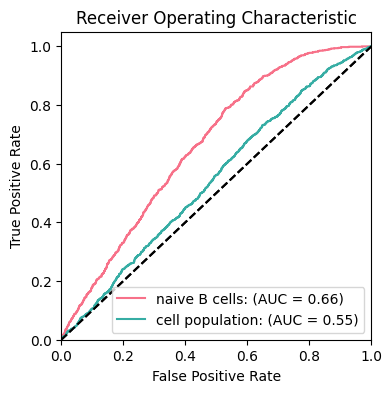

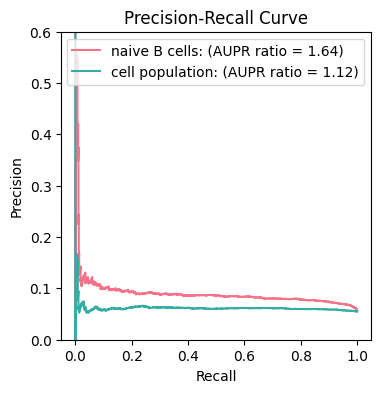

In [104]:
outdir = os.path.join(os.getcwd(),'results/LINGER_output/')
TFName = 'CTCF'
Method_name=['naive B cells','cell population']
Infer_trans=[outdir+'cell_type_specific_trans_regulatory_naive B cells.txt',outdir+'cell_population_trans_regulatory.txt']
Groundtruth=os.path.join(os.getcwd(),'data/gt/45178_gene_score_5fold.txt')
from LingerGRN import Benchmk
Benchmk.bm_trans(TFName,Method_name,Groundtruth,Infer_trans,outdir,'matrix')


For *CTCF* in B lymphocytes AUROC is 0.66 and AUPR ratio is 1.64.

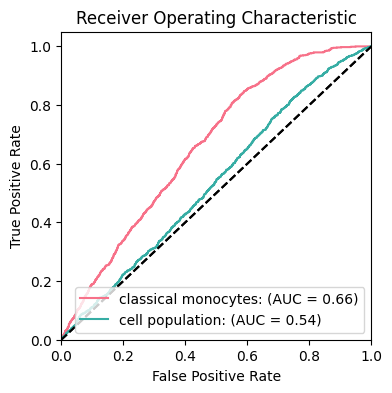

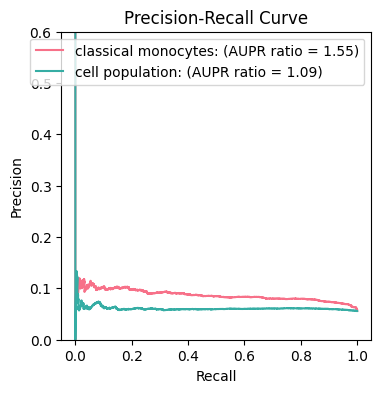

In [105]:
TFName = 'CTCF'
Method_name=['classical monocytes','cell population']
Infer_trans=[outdir+'cell_type_specific_trans_regulatory_classical monocytes.txt',outdir+'cell_population_trans_regulatory.txt']
Groundtruth=os.path.join(os.getcwd(),'data/gt/45444_gene_score_5fold.txt')
Benchmk.bm_trans(TFName,Method_name,Groundtruth,Infer_trans,outdir,'matrix')


For *CTCF* in classical monocytes AUROC is 0.66 and AUPR ratio is 1.55. So we have:


| TF   | cell type           | AUC  | AUPRR |
|------|---------------------|------|-------|
| CTCF | naive B cells       | 0.66 | 1.64  |
| CTCF | classical monocytes | 0.66 | 1.55  |

However, this is not consistent wwith the result from the original publication (Supplementary Data Table 7).

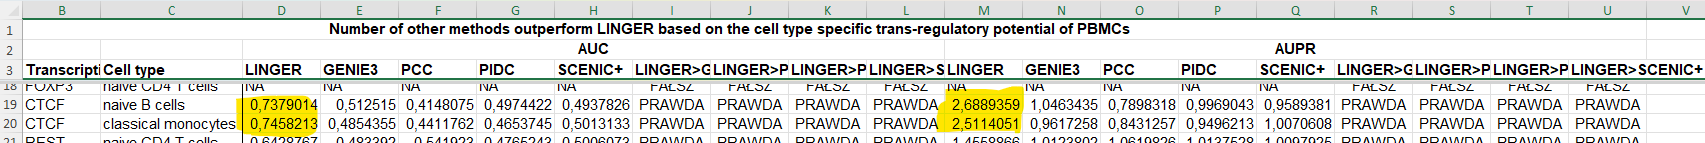

| TF   | cell type           | AUC      | AUPRR    |
|------|---------------------|----------|----------|
| CTCF | naive B cells       | 0,737901 | 2,688936 |
| CTCF | classical monocytes | 0,745821 | 2,511405 |

# Results

The analysis aimed to reproduce the results reported in the original paper. The benchmarking set for *trans*-regulatory potential consists of 20 datasets from downloaded from CistromeDB which IDs are specified below along with TF names (`ids`, `tfs`). The data in CistromeDB are linked to specific cell-type and `cell_types` specifies corresponding labels from our data. 

In [ ]:
ids = [5967, 8481, 40215, 41287, 41288, 41289, 41290, 41301, 41302, 41303, 44092, 44093, 44094, 44097, 44098, 45178, 45444, 47435, 81223, 85986]
tfs = ["MYC", "RUNX1", "IRF4", "STAT1", "STAT1", "STAT1", "STAT1", "IRF1", "IRF1", "IRF1", "ETS1", "ETS1", "ETS1", "RUNX1", "FOXP3", "CTCF", "CTCF", "REST", "RUNX1", "SPI1"]
cell_types = ["naive B cells", "myeloid DC", "naive B cells", "classical monocytes", "classical monocytes", "classical monocytes", "classical monocytes", "classical monocytes", "classical monocytes", "classical monocytes", "naive CD4 T cells", "naive CD4 T cells", "naive CD4 T cells", "naive CD4 T cells", "naive CD4 T cells", "naive B cells", "classical monocytes", "naive CD4 T cells", "classical monocytes", "classical monocytes"]

We modified the benchmarking function from `LINGER` to manipulate numerical results apart from generated pictures.

*Previously used code with unmodified function.*
```
from LingerGRN import Benchmk

for i, tf in enumerate(tfs):
    Method_name=[cell_types[i],'cell population']
    Infer_trans=[outdir+f'cell_type_specific_trans_regulatory_{cell_types[i]}.txt',outdir+'cell_population_trans_regulatory.txt']
    Groundtruth = f'/home/kl467102/thesis/data/gt/{ids[i]}_gene_score_5fold.txt'
    auc = Benchmk.bm_trans(tfs[i],Method_name,Groundtruth,Infer_trans,outdir,'matrix')
    print(f'Benchamrked {tf}, {i+1}/{len(tfs)}')
```

In [ ]:
from LingerGRN import Benchmk_modified

for i, tf in enumerate(tfs):
    Method_name=[cell_types[i],'cell population']
    Infer_trans=[outdir+f'cell_type_specific_trans_regulatory_{cell_types[i]}.txt',outdir+'cell_population_trans_regulatory.txt']
    Groundtruth = f'/home/kl467102/thesis/data/gt/{ids[i]}_gene_score_5fold.txt'
    auc = Benchmk_modified.bm_trans(tfs[i],Method_name,Groundtruth,Infer_trans,outdir,'matrix')
    AUCs[ids[i]] = auc
    #print(f'Benchamrked {tf}, {i+1}/{len(tfs)}')
#print(AUCs)

In [73]:
results_df = pd.DataFrame.from_dict(AUCs, orient='index')
results_df['CistromeID'] = results_df.index
results_df

,sample,auc_cell_type,auc_population,aupr_ratio_cell_type,aupr_ratio_population,CistromeID
5967,MYC,0.729713,0.594224,2.161014,1.193612,5967
8481,RUNX1,0.715148,0.644184,2.301199,1.639014,8481
40215,IRF4,0.647396,0.537879,1.452026,1.083941,40215
41287,STAT1,0.734969,0.649429,2.174876,1.741486,41287
41288,STAT1,0.756534,0.698884,2.461779,2.043635,41288
41289,STAT1,0.751269,0.661973,2.290563,1.844291,41289
41290,STAT1,0.729924,0.660704,2.198799,1.773183,41290
41301,IRF1,0.750873,0.714962,2.730108,2.323006,41301
41302,IRF1,0.721382,0.718530,2.462494,2.407338,41302
41303,IRF1,0.737552,0.708748,2.773730,2.409324,41303


In [99]:
results_df.to_csv('results/LINGER_trans_benchmarking.csv')

In [84]:
article_auc = pd.read_csv('data/sup_tab_7_auc.csv',header = 1,sep=';',decimal=',')
article_aupr = pd.read_csv('data/sup_tab_7_aupr.csv',header = 1,sep=';',decimal=',')

In [85]:
merged_df = pd.merge(article_auc, article_aupr, on=['CistromeID','Transcription factor','Cell type'], suffixes=('_auc', '_aupr'))

In [98]:
full_results = pd.merge(merged_df, results_df, on = 'CistromeID').drop(columns=['sample'])
full_results['AUC_diff'] = abs(full_results['LINGER_auc']- full_results['auc_cell_type'])
full_results['AUPR_diff'] = abs(full_results['LINGER_aupr']- full_results['aupr_ratio_cell_type'])
full_results.head()

,CistromeID,Transcription factor,Cell type,LINGER_auc,GENIE3_auc,PCC_auc,PIDC_auc,SCENIC+_auc,LINGER_aupr,GENIE3_aupr,PCC_aupr,PIDC_aupr,SCENIC+_aupr,auc_cell_type,auc_population,aupr_ratio_cell_type,aupr_ratio_population,AUC_diff,AUPR_diff
0,5967,MYC,naive B cells,0.720133,0.502780,0.567367,0.505407,0.540907,2.413374,1.040413,1.362792,1.000683,1.591839,0.729713,0.594224,2.161014,1.193612,0.009580,0.252360
1,8481,RUNX1,myeloid DC,0.758330,0.530228,0.485805,0.518999,0.518733,2.676380,1.033743,0.984470,1.053067,1.151790,0.715148,0.644184,2.301199,1.639014,0.043182,0.375181
2,40215,IRF4,naive B cells,0.707885,0.490454,0.470572,0.500014,0.517287,2.093101,1.002965,1.025987,1.033662,1.106470,0.647396,0.537879,1.452026,1.083941,0.060489,0.641075
3,41287,STAT1,classical monocytes,0.757319,0.587763,0.585599,0.565887,0.567662,2.661258,1.361098,1.278436,1.300054,1.261736,0.734969,0.649429,2.174876,1.741486,0.022350,0.486382
4,41288,STAT1,classical monocytes,0.735052,0.612114,0.587097,0.602443,0.576049,2.409937,1.515576,1.309550,1.621629,1.360996,0.756534,0.698884,2.461779,2.043635,0.021482,0.051842


In [53]:
import importlib
import LingerGRN
from LingerGRN import Benchmk
importlib.reload(LingerGRN)


<module 'LingerGRN' (<_frozen_importlib_external._NamespaceLoader object at 0x7f9f09317850>)>

# Session information

In [111]:
import session_info
session_info.show()

In [112]:
from importlib.metadata import version
pkg_version = version('LingerGRN')
print(f'LingerGRN version: {pkg_version}')


LingerGRN version: 1.97
